## Solving for thermal advection and diffusion in 2D using the Fenics library

John J. Armitage

Abstract:
This is an enxample note book to explore if we can make a submission process for a subsurface online reproducable journal. This notebook has been written to solve classic advection diffusion. The notebook uses for packages: fenics, mshr, and numpy.

Introduction:
This is an example of using the fenics library to solve for the thermal advection and diffusion in two dimensions. The equations are solved using the finite element technique within a cartesian box. The velocity of the material within the box is predefined ans a linear function of space. The aim of this notebook is simply to explore how to deal with such a notebook and how to test it for reproducability.

In [1]:
%matplotlib inline
from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt

conda install -c conda-forge fenics

conda install -c conda-forge mshr

I will set up the domain dimensions for the rectanular box and the model resolution.

In [2]:
# Domain dimensions in meters
lx = 1.5e5
lz = 1.0e5
# number of elements along z-edge
numz = 32 

Here I define the physical parameters that are used within the model and the time stepping for the numerical solution.

In [3]:
# Physical parameters
year      = 365*24*60*60
K         = 1e-6  # thermal diffusivity

# Time steps
num_steps = 20       # number of time steps
dtnom     = 1e5*year   # time step size (in years)
dtc       = Constant(dtnom) 

Now I am ready to define and solve the set of equations. The first step is to create the mesh using the library mshr and display the mesh.

Text(0.5,1,'Mesh')

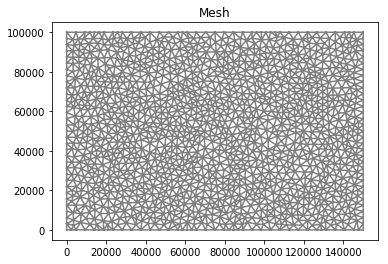

In [4]:
# Create mesh and define function space
domain = Rectangle(Point(0,0), Point(lx,lz))
mesh = generate_mesh(domain,numz)
p = plot(mesh)
plt.title("Mesh")

Then define the functions in which temperature and velocity will be stored.

In [5]:
# Define function space for temperature
V = FunctionSpace(mesh,'CG',1)
# Define function space for velocity
W = VectorFunctionSpace(mesh,'P',2)

Define the intial conditions

In [6]:
T_D   = Expression('x[1]>=lz-10e3 ? 1450 : 0',lz=lz,degree=2)
T_n = interpolate(T_D, V)


Create the boundary conditions

In [7]:
class East(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[0], lx)

class West(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[0], 0.0)

class North(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[1], lz)

class South(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[1], 0.0)

Tbc   = DirichletBC(V,T_D,North())

We then define the test and trial functions.

In [8]:
# Define variational problem

#T Temperature
T = TrialFunction(V)
vt = TestFunction(V)

The velocity of the material is defined as linarly increasing in the x direction and decreasing in the positive z direction.

In [9]:
# solid flow
u = Expression(('1e-2/year/lz*(lz-x[1])','-1e-2/year/lz*(lx-x[0])'),year=year,lz=lz,lx=lx,degree=2)

Finally we form the PDE to be solved.

In [10]:
# PDE for temperature
Ft = ((T-T_n)/dtc)*vt*dx + dot(u,grad(T))*vt*dx + K*dot(grad(T),grad(vt))*dx
a1, L1 = lhs(Ft), rhs(Ft)

We now use a for loop to march forward in time to solve for temperature.

In [11]:
# Time-stepping
T = Function(V)
#phi = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dtc
      
    # Compute solution
    # solve(Ft == 0, T)
    solve(a1 == L1, T, Tbc)
             
    # Update previous solution
    T_n.assign(T)

                

The final temperature field is then plotted below.

(100000, 0)

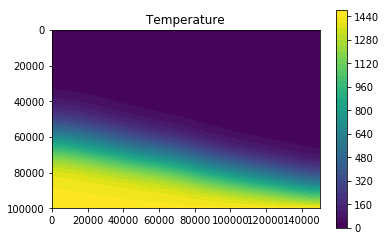

In [12]:
p = plot(T)
# set colormap
p.set_cmap("viridis")
p.set_clim(0,1450)
# add a title to the plot
plt.title("Temperature")
# add a colorbar
plt.colorbar(p)
plt.ylim(100000,0)